In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from .utils import PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
from river.models.utils import *
from river.data.utils import *

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
#from river.data.dataset import #DatasetStrainFD, #DatasetStrainFDFromPreCalSVDWF
#import river.data.utils as datautils
from river.data.utils import *
from river.data.reparameterize import *

from river.models import embedding
from river.models.utils import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
#from sklearn.utils.extmath import randomized_svd
import sklearn
from sklearn.decomposition import IncrementalPCA, randomized_svd, KernelPCA
import sklearn.decomposition 

import glob
import time

In [3]:
validfolder = '/home/qian.hu/mlpe/training_data/bns_20Hz_mb/valid'
trainfolder = '/home/qian.hu/mlpe/training_data/bns_20Hz_mb/train'
#noisefolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin/noise/design'

valid_filenames = glob.glob(f"{validfolder}/batch*/*.h5")
train_filenames = glob.glob(f"{trainfolder}/batch*/*.h5")

In [35]:
testf = load_dict_from_hdf5(valid_filenames[0])

In [38]:
farray = testf['frequency_array']

In [159]:
torch.fft.ifft?

In [8]:
def load_asd(data_folder, detector_names, freqs_interp=None, is_asd=True):
    asd_dict = {}
    for detname in detector_names:
        asd_dict[detname] = []
        filenames = glob.glob(f"{data_folder}/{detname}/*.txt")
        for filename in filenames:
            asd = np.loadtxt(filename)
            if freqs_interp is not None:
                asd_interp = np.interp(freqs_interp, asd[:,0], asd[:,1])
            else:
                asd_interp = asd[:,1]
            if not is_asd:
                asd_interp = asd_interp**0.5
            asd_dict[detname].append(asd_interp)
    return asd_dict

In [7]:
asd_folder = '/home/qian.hu/mlpe/training_data/psd/LHVdesign'

In [49]:
asd_dict = load_asd('/home/qian.hu/mlpe/training_data/psd/LHVdesign', ['H1', 'L1', "V1"], farray)

In [9]:
import random

In [58]:
random.choice([1])

1

In [ ]:
T/4 , T=300s

In [ ]:
each band, whiten with the same norm factor 300/4

In [15]:

class DatasetMBStrainFDFromMBWFonGPU(Dataset):
    '''
    Simulate multiband FD data from pre-calculated multiband waveforms, optimized for GPU or CPU computation.
    '''
    def __init__(self, wf_folder, asd_folder, parameter_names, full_duration, detector_names,
                dmin=10, dmax=200, dpower=1, device='cuda', 
                add_noise=True, fix_extrinsic=False, shuffle=False, reparameterize=True,
                 use_sealgw_detector=False, is_asd=True, random_asd = False):
        
        self.precalwf_filelist = glob.glob(f"{wf_folder}/batch*/*.h5")
        self.parameter_names = parameter_names
        self.full_duration = full_duration
        
        self.dmin = dmin
        self.dmax = dmax
        self.dpower = dpower
        self.device = device
        self.add_noise = add_noise
        self.fix_extrinsic = fix_extrinsic
        self.shuffle = shuffle
        self.reparameterize = reparameterize
        self.random_asd = random_asd
        
        self.detector_names = detector_names
        if use_sealgw_detector:
            self.ifos = sealsim.sealinterferometers.SealInterferometerList(detector_names)
        else:
            self.ifos = bilby.gw.detector.InterferometerList(detector_names)
            
        #for det in self.ifos:
        #    det.sampling_frequency = 2048
        #    det.duration = self.full_duration
            #det.frequency_mask = (det.frequency_array >= self.f_low) * (det.frequency_array <= self.f_high)
        #    if use_sealgw_detector:
        #        det.antenna_response_change = True
        
        
        #self.det_data = self.prepare_detector_data()
        
        testfile = load_dict_from_hdf5(self.precalwf_filelist[0])
        self.sample_per_file = len(testfile['injection_parameters']['chirp_mass'])
        self.Nfile = len(self.precalwf_filelist)
        self.Nsample = self.Nfile * self.sample_per_file 
        self.cached_wf_file = testfile
        self.cached_wf_file_index = 0
        self.farray = torch.from_numpy(testfile['frequency_array']).float().to(self.device)
        self.Npoint = len(self.farray)
        self.asd_dict = load_asd(asd_folder, detector_names, freqs_interp=testfile['frequency_array'], is_asd=is_asd)
        
        self.shuffle_indexinfile()
    '''
    def prepare_detector_data(self):
        det_data = {}
        for det in self.ifos:
            detname = det.name
            psd = det.power_spectral_density_array[self.data_generator.frequency_mask]
            psd = torch.from_numpy(psd).double().to(self.device)
            whitened_V = (self.V.T * 1/(psd*det.duration/4)**0.5).T
            det_data[detname] = {'whitened_V': whitened_V.type(torch.complex64)}
        return det_data'''

    def __len__(self):
        return len(self.precalwf_filelist) * self.sample_per_file

    def __getitem__(self, index):
        index_of_file, index_in_file = self.get_index(index, self.sample_per_file)
        wf_dict = self.get_precalwf_dict(index_of_file)
        hp_mb, hc_mb = self.get_waveform_tensors(wf_dict, index_in_file)

        injection_parameters = self.get_injection_parameters(wf_dict,index_in_file)
        injection_parameters = self.update_injection_parameters(injection_parameters)
        hp_mb = hp_mb/injection_parameters['luminosity_distance']
        hc_mb = hc_mb/injection_parameters['luminosity_distance']
        x = self.compute_strain_tensors(hp_mb, hc_mb, injection_parameters)

        theta = self.get_theta(injection_parameters)
        print(x.shape)
        print(torch.cat((x.real, x.imag)).shape)
        return theta, torch.cat((x.real, x.imag)).float()

    def get_index(self, index, sample_per_file):
        index_of_file = index // sample_per_file
        index_in_file = index - index_of_file*sample_per_file
        
        return index_of_file, index_in_file
    
    def get_precalwf_dict(self, index_of_file):
        if self.cached_wf_file_index == index_of_file:
            return self.cached_wf_file
        else:
            wf_dict = load_dict_from_hdf5(self.precalwf_filelist[index_of_file])
            self.cached_wf_file = wf_dict
            self.cached_wf_file_index = index_of_file
            return wf_dict
        
    def get_waveform_tensors(self, wf_dict, index_in_file):
        index_in_file = self.random_index_in_file[index_in_file]
        hp = (torch.from_numpy(wf_dict['waveforms'][2*index_in_file]).type(torch.complex64)).to(self.device)
        hc = (torch.from_numpy(wf_dict['waveforms'][2*index_in_file+1]).type(torch.complex64)).to(self.device)
        return hp, hc

    def get_injection_parameters(self, wf_dict, index_in_file):
        index_in_file = self.random_index_in_file[index_in_file]
        injection_parameters = {key: wf_dict['injection_parameters'][key][index_in_file] for key in ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']}
        return injection_parameters

    def get_noise_tensors(self, ):
        white_noise = (torch.randn(self.Npoint, device=self.device) + 1j * torch.randn(self.Npoint, device=self.device)).type(torch.complex64)

        return white_noise
    
    def compute_strain_tensors(self, hp_mb, hc_mb, injection_parameters):
        num_ifos = len(self.ifos)
        x = torch.zeros((num_ifos, self.Npoint), dtype=torch.complex64, device=self.device)
        for i, det in enumerate(self.ifos):
            detname = det.name
            
            fp, fc, dt = self.compute_detector_factors(det, injection_parameters)
            phase2add = torch.exp(-1j * 2 * np.pi * dt * self.farray)            
            h_mb = (fp*hp_mb + fc*hc_mb).type(torch.complex64) * phase2add
            if self.random_asd:
                whiten_factor = 1/random.choice(self.asd_dict[detname]) * 1/(self.full_duration/4)**0.5
            else:
                whiten_factor = 1/self.asd_dict[detname][0] * 1/(self.full_duration/4)**0.5
                
            whiten_factor = torch.from_numpy(whiten_factor).to(self.device)
            h_mb_whitened = h_mb * whiten_factor
            if self.add_noise:
                n_mb = self.get_noise_tensors()
                d_mb = h_mb_whitened + n_mb
            else:
                d_mb = h_mb_whitened
            
            x[i] = d_mb
        return x

    def compute_detector_factors(self, det, injection_parameters):
        # These calculations remain on CPU as they cannot be efficiently vectorized or moved to GPU
        ra = injection_parameters['ra']
        dec = injection_parameters['dec']
        tc = injection_parameters['geocent_time']
        psi = injection_parameters['psi']
        fp = det.antenna_response(ra , dec, tc, psi, 'plus')
        fc = det.antenna_response(ra , dec, tc, psi, 'cross')
        time_shift = det.time_delay_from_geocenter(ra , dec, tc)
        
        dt_geocent = tc #- self.strain_data.start_time
        dt = dt_geocent + time_shift
            
        return fp, fc, dt

    def get_theta(self, injection_parameters):
        if self.fix_extrinsic:
            parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        else:
            parameter_names = self.parameter_names
        
        theta_list = []
        for paraname in parameter_names:
            if self.reparameterize:
                para_re = reparameterize(injection_parameters[paraname], paraname)
            else:
                para_re = injection_parameters[paraname]
            theta_list.append(para_re)
        theta_array = np.array(theta_list)
        theta = torch.tensor(theta_array, dtype=torch.float32).to(self.device).T
    
        return theta
    
    def update_injection_parameters(self, injection_parameters):
        if self.fix_extrinsic:
            injection_parameters['ra'] = 1
            injection_parameters['dec'] = 1
            injection_parameters['psi'] = 1
            injection_parameters['geocent_time'] = 0
            #injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=1, low=self.dmin, high=self.dmax, power=self.dpower)[0]
            injection_parameters['luminosity_distance'] = 100
        else:
            injection_parameters['ra'] = np.random.uniform(0, 2*np.pi)
            injection_parameters['dec'] = np.arcsin(np.random.uniform(-1, 1))
            injection_parameters['psi'] = np.random.uniform(0, np.pi)
            injection_parameters['geocent_time'] = np.random.uniform(-0.1, 0.1)
            injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=1, low=self.dmin, high=self.dmax, power=self.dpower)[0]
    
        return injection_parameters
    
    def shuffle_wflist(self):
        #if self.shuffle:
        random.shuffle(self.precalwf_filelist)
        
    def shuffle_indexinfile(self):
        if self.shuffle:
            raise Exception('Not implemeted')
            #self.random_index_in_file = np.random.permutation(self.sample_per_file)
        else:
            self.random_index_in_file = np.arange(self.sample_per_file)


In [16]:
class DatasetMBStrainFDFromMBWFonGPUBatch(DatasetMBStrainFDFromMBWFonGPU):
    '''
    Simulate multiband FD data from pre-calculated multiband waveforms, optimized for GPU or CPU computation.
    '''
    def __init__(self, wf_folder, asd_folder, parameter_names, full_duration, detector_names,
                dmin=10, dmax=200, dpower=1, device='cuda', minibatch_size=1,
                add_noise=True, fix_extrinsic=False, shuffle=False, reparameterize=True,
                 use_sealgw_detector=False, is_asd=True, random_asd = False):
        super().__init__(wf_folder, asd_folder, parameter_names, full_duration, detector_names, dmin, dmax, dpower, device,
                        add_noise, fix_extrinsic, shuffle, reparameterize, use_sealgw_detector, is_asd, random_asd)
        self.minibatch_size = minibatch_size
        
    def __len__(self):
        return len(self.precalwf_filelist) * self.sample_per_file // self.minibatch_size
    
    def __getitem__(self, index):
        index = index*self.minibatch_size
        
        index_end = index + self.minibatch_size
        index_of_file, index_in_file = self.get_index(index, self.sample_per_file)
        index_of_file_end, index_in_file_end = self.get_index(index_end, self.sample_per_file)
        if index_of_file_end>=len(self.precalwf_filelist):
            index_of_file_end = len(self.precalwf_filelist)-1
            index_in_file_end = self.sample_per_file
        wf_dict_list = []
        for i in range(index_of_file, index_of_file_end+1):
            wf_dict_list.append(self.get_precalwf_dict(i))
        
        hp_mb, hc_mb = self.get_waveform_tensors_batch(wf_dict_list, index_in_file, index_in_file_end)
        injection_parameters = self.get_injection_parameters_batch(wf_dict_list,index_in_file, index_in_file_end)
        injection_parameters = self.update_injection_parameters_batch(injection_parameters)
        
        dL = torch.from_numpy(injection_parameters['luminosity_distance']).to(self.device).unsqueeze(-1)
        hp_mb = hp_mb/dL
        hc_mb = hc_mb/dL

        x = self.compute_strain_tensors_batch(hp_mb, hc_mb, injection_parameters)

        theta = self.get_theta(injection_parameters)

        return theta, torch.cat((x.real, x.imag), axis=1).float()
    
    def get_precalwf_dict(self, index_of_file):
        if self.cached_wf_file_index == index_of_file:
            return self.cached_wf_file
        else:
            try:
                wf_dict = load_dict_from_hdf5(self.precalwf_filelist[index_of_file])
            except:
                raise Exception(f'index_of_file: {index_of_file}')
            self.cached_wf_file = wf_dict
            self.cached_wf_file_index = index_of_file
        return wf_dict
    
    def get_waveform_tensors_batch(self, wf_dict_list, index_in_file, index_in_file_end):
        for i, wf_dict in enumerate(wf_dict_list):
            if i==len(wf_dict_list)-1:
                end_index = index_in_file_end
            else:
                end_index = self.sample_per_file
                
            index = self.random_index_in_file[index_in_file:end_index]
            index_p = 2*index
            index_c = 2*index + 1
            if i==0:
                hp = (torch.from_numpy(wf_dict['waveforms'][index_p]).type(torch.complex64)).to(self.device)
                hc = (torch.from_numpy(wf_dict['waveforms'][index_c]).type(torch.complex64)).to(self.device)
        
            else:
                hp_new = (torch.from_numpy(wf_dict['waveforms'][index_p]).type(torch.complex64)).to(self.device)
                hc_new = (torch.from_numpy(wf_dict['waveforms'][index_c]).type(torch.complex64)).to(self.device)
                
                hp = torch.cat((hp,hp_new))
                hc = torch.cat((hc,hc_new))
                    
        return hp, hc    
    
    def get_injection_parameters_batch(self, wf_dict_list, index_in_file, index_in_file_end):
        para_name_list = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        for i, wf_dict in enumerate(wf_dict_list):
            if i==len(wf_dict_list)-1:
                end_index = index_in_file_end
            else:
                end_index = self.sample_per_file

            index_random = self.random_index_in_file[index_in_file:end_index]
            if i==0:
                injection_parameters = {key: wf_dict['injection_parameters'][key][index_random] for key in para_name_list}
            else:
                injection_parameters = {key: np.append(injection_parameters[key], wf_dict['injection_parameters'][key][index_random]) for key in para_name_list}

        return injection_parameters
    
    def get_noise_tensors_batch(self, ):
        white_noise = (torch.randn((self.minibatch_size, self.Npoint), device=self.device) + \
                       1j * torch.randn((self.minibatch_size, self.Npoint), device=self.device)).type(torch.complex64)

        return white_noise
    
    
    def compute_strain_tensors_batch(self, hp_mb, hc_mb, injection_parameters):
        num_ifos = len(self.ifos)
        x = torch.zeros((self.minibatch_size, num_ifos, self.Npoint), dtype=torch.complex64, device=self.device)
        for i,det in enumerate(self.ifos):
            detname = det.name
        
            fp, fc, dt = self.compute_detector_factors_batch(det, injection_parameters)
            phase2add = torch.exp(-1j * 2 * np.pi * dt * self.farray)
            h_mb = (fp*hp_mb + fc*hc_mb).type(torch.complex64) * phase2add#.unsqueeze(0)
            
            if self.random_asd:
                whiten_factor = 1/random.choice(self.asd_dict[detname]) * 1/(self.full_duration/4)**0.5
            else:
                whiten_factor = 1/self.asd_dict[detname][0] * 1/(self.full_duration/4)**0.5
                
            whiten_factor = torch.from_numpy(whiten_factor).to(self.device)
            h_mb_whitened = h_mb * whiten_factor
            
            if self.add_noise:
                n_mb = self.get_noise_tensors_batch()
                d_mb = h_mb_whitened + n_mb
            else:
                d_mb = h_mb_whitened
            
            x[:,i,:] = d_mb
            
        return x
        
        
    def compute_detector_factors_batch(self, det, injection_parameters):
        ra = injection_parameters['ra'][0]
        dec = injection_parameters['dec'][0]
        tc = injection_parameters['geocent_time'][0]
        psi = injection_parameters['psi'][0]

        fp = det.antenna_response(ra, dec, tc, psi, 'plus')
        fc = det.antenna_response(ra, dec, tc, psi, 'cross')
        time_shift = det.time_delay_from_geocenter(ra, dec, tc)

        dt_geocent = tc #- self.strain_data.start_time
        dt = dt_geocent + time_shift
        
        return fp, fc, dt
    
    def update_injection_parameters_batch(self, injection_parameters):
        if self.fix_extrinsic:
            injection_parameters['ra'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['dec'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['psi'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['geocent_time'] = np.zeros(self.minibatch_size) + 0
            #injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=self.minibatch_size, low=self.dmin, high=self.dmax, power=self.dpower)
            injection_parameters['luminosity_distance'] = np.zeros(self.minibatch_size) + 100
    
        else:
            injection_parameters['ra'] = np.zeros(self.minibatch_size) + np.random.uniform(0, 2*np.pi)
            injection_parameters['dec'] = np.zeros(self.minibatch_size) + np.arcsin(np.random.uniform(-1, 1))
            injection_parameters['psi'] = np.zeros(self.minibatch_size) + np.random.uniform(0, np.pi)
            injection_parameters['geocent_time'] = np.zeros(self.minibatch_size) + np.random.uniform(-0.1, 0.1)
            injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=self.minibatch_size, low=self.dmin, high=self.dmax, power=self.dpower)
        
        return injection_parameters

In [17]:
dataset = DatasetMBStrainFDFromMBWFonGPU(wf_folder=validfolder, asd_folder=asd_folder, parameter_names=PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY,
                                        full_duration = 320, detector_names=['H1', 'L1', "V1"],
                                        add_noise=False, fix_extrinsic=True)

dataset_batch = DatasetMBStrainFDFromMBWFonGPUBatch(wf_folder=validfolder, asd_folder=asd_folder, parameter_names=PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY,
                                                    full_duration = 320, detector_names=['H1', 'L1', "V1"], minibatch_size=500,
                                                    add_noise=False, fix_extrinsic=True)

In [18]:
%time theta_batch, x_batch = dataset_batch[0]

CPU times: user 59.2 ms, sys: 63.9 ms, total: 123 ms
Wall time: 92.6 ms


In [19]:
%time theta, x = dataset[0]

torch.Size([3, 3328])
torch.Size([6, 3328])
CPU times: user 4.99 ms, sys: 797 µs, total: 5.79 ms
Wall time: 6.18 ms


In [13]:
x.shape

torch.Size([6, 3328])

In [14]:
x_batch.shape

torch.Size([500, 6, 3328])

In [34]:
torch.cat((dataset_batch.farray.repeat((dataset_batch.minibatch_size,1,1)), x_batch), axis=1)[0]

tensor([[ 2.0000e+01,  2.0005e+01,  2.0011e+01,  ...,  1.0174e+03,
          1.0202e+03,  1.0230e+03],
        [-5.4171e-02, -8.4331e-03,  4.3321e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 4.4251e-02, -7.1922e-03, -5.3757e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 3.5363e-02,  6.4227e-02,  4.8278e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-4.7418e-02, -6.4552e-02, -3.6621e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.2030e-02,  3.8492e-03, -2.7100e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')

In [155]:
theta_batch[1], theta

(tensor([ 0.0464,  1.4700, -0.3630,  0.2447, -0.6844,  1.1424,  0.2844,  0.3657,
          0.0801,  1.3727, -0.2890, -1.5035], device='cuda:0'),
 tensor([ 1.1033,  0.5978,  0.6053, -1.4789,  1.5384, -0.1803,  0.2553,  0.4018,
         -0.7276,  0.0374,  1.2129, -1.5956], device='cuda:0'))

In [156]:
x_batch[1], x

(tensor([[-9.9783e-03, -7.4500e-03, -4.7740e-03,  ...,  6.6271e-05,
           3.5846e-05,  1.4082e-05],
         [-2.8423e-03, -4.6780e-03, -6.3652e-03,  ..., -3.8791e-05,
          -2.2168e-05, -9.7789e-06],
         [ 1.8535e-02,  1.6927e-02,  1.4906e-02,  ...,  2.3920e-05,
           2.0026e-05,  1.4661e-05],
         [-1.5444e-02, -1.6703e-02, -1.7554e-02,  ...,  6.0094e-05,
           5.6385e-05,  4.5775e-05],
         [ 1.2019e-02,  1.1323e-02,  1.0351e-02,  ..., -2.6404e-05,
          -2.6958e-05, -2.2914e-05],
         [ 8.9801e-03,  1.1759e-02,  1.4257e-02,  ..., -1.3567e-05,
          -4.5275e-06,  1.0444e-06]], device='cuda:0'),
 tensor([[-0.0542, -0.0084,  0.0433,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0443, -0.0072, -0.0538,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0224,  0.0390,  0.0283,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0354,  0.0642,  0.0483,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0474, -0.0646, -0.0366,  ...,  0.0000,  0.0000,  0.000

In [157]:
len(np.where(abs(x[0].detach().cpu()) == 0)[0])

59

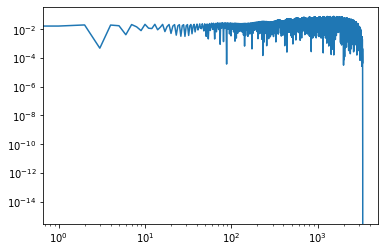

In [148]:
plt.loglog(abs(x[0].detach().cpu()))

In [140]:
x_batch[1]-x

tensor([[ 2.3283e-09,  0.0000e+00, -1.8626e-09,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  1.1642e-09,  1.8626e-09,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  9.3132e-10,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -5.2387e-10,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')

In [141]:
torch.max(x_batch[1]-x)

tensor(1.4901e-08, device='cuda:0')

In [ ]:

class DatasetSVDStrainFDFromSVDWFonGPUBatch(Dataset):
    '''
    Simulate FD data in SVD space from pre-calculated SVD waveforms, optimized for GPU or CPU computation.

    Load a batch of data, i.e. return [minibatch_size, dim1, dim2, ...]. The batch size should be 2^N. 
    '''
    def __init__(self, precalwf_filelist, parameter_names, data_generator, Nbasis, Vhfile,
                dmin=10, dmax=200, dpower=1, loadwf=False, loadnoise=False, device='cuda',
                is_complex=False, add_noise=True, minibatch_size=1, fix_extrinsic=False, shuffle=True, reparameterize=True):
        self.precalwf_filelist = precalwf_filelist
        self.parameter_names = parameter_names
        self.data_generator = data_generator
        self.Nbasis = Nbasis
        self.dmin = dmin
        self.dmax = dmax
        self.dpower = dpower
        self.loadwf = loadwf
        self.loadnoise = loadnoise
        self.device = device
        self.minibatch_size = minibatch_size
        self.complex = is_complex
        self.add_noise = add_noise
        self.fix_extrinsic = fix_extrinsic
        self.shuffle = shuffle
        self.reparameterize = reparameterize

        # Load V and Vh matrices and convert to tensors
        self.V, self.Vh = loadVandVh(Vhfile, Nbasis)
        self.V = torch.from_numpy(self.V).to(self.device).type(torch.complex64)
        self.Vh = torch.from_numpy(self.Vh).to(self.device).type(torch.complex64)

        
        self.farray = torch.from_numpy(data_generator.frequency_array_masked).float().to(self.device)
        self.ifos = data_generator.ifos
        self.det_data = self.prepare_detector_data()
        
        testfile = load_dict_from_hdf5(precalwf_filelist[0])
        self.sample_per_file = len(testfile['injection_parameters']['chirp_mass'])
        #if self.sample_per_file<self.minibatch_size:
        #    raise ValueError("Sample per file < batch size!")
        self.Nfile = len(self.precalwf_filelist)
        self.Nsample = self.Nfile * self.sample_per_file 
        self.cached_wf_file = testfile
        self.cached_wf_file_index = 0
            
        self.shuffle_indexinfile()
        
    def prepare_detector_data(self):
        det_data = {}
        for det in self.ifos:
            detname = det.name
            psd = det.power_spectral_density_array[self.data_generator.frequency_mask]
            psd = torch.from_numpy(psd).double().to(self.device)
            whitened_V = (self.V.T * 1/(psd*det.duration/4)**0.5).T
            det_data[detname] = {'whitened_V': whitened_V.type(torch.complex64)}
        return det_data

    def __len__(self):
        return len(self.precalwf_filelist) * self.sample_per_file // self.minibatch_size

    def __getitem__(self, index):
        index = index*self.minibatch_size
        
        index_end = index + self.minibatch_size
        index_of_file, index_in_file = self.get_index(index, self.sample_per_file)
        index_of_file_end, index_in_file_end = self.get_index(index_end, self.sample_per_file)
        if index_of_file_end>=len(self.precalwf_filelist):
            index_of_file_end = len(self.precalwf_filelist)-1
            index_in_file_end = self.sample_per_file
        wf_dict_list = []
        for i in range(index_of_file, index_of_file_end+1):
            wf_dict_list.append(self.get_precalwf_dict(i))
        
        hp_svd, hc_svd = self.get_waveform_tensors_batch(wf_dict_list, index_in_file, index_in_file_end)
        injection_parameters = self.get_injection_parameters_batch(wf_dict_list,index_in_file, index_in_file_end)
        injection_parameters = self.update_injection_parameters_batch(injection_parameters)
        
        dL = torch.from_numpy(injection_parameters['luminosity_distance']).to(self.device).unsqueeze(-1)
        hp_svd = hp_svd/dL
        hc_svd = hc_svd/dL

        #x_real, x_imag = self.compute_strain_tensors_batch(hp_svd, hc_svd, injection_parameters)
        x = self.compute_strain_tensors_batch(hp_svd, hc_svd, injection_parameters)

        theta = self.get_theta(injection_parameters)
        if self.complex:
            return theta, x 
        else:
            return theta, torch.cat((x.real, x.imag), axis=1).float()

    def get_index(self, index, sample_per_file):
        index_of_file = index // sample_per_file
        index_in_file = index - index_of_file*sample_per_file

        return index_of_file, index_in_file
    
    def get_precalwf_dict(self, index_of_file):
        if self.cached_wf_file_index == index_of_file:
            return self.cached_wf_file
        else:
            try:
                wf_dict = load_dict_from_hdf5(self.precalwf_filelist[index_of_file])
            except:
                raise Exception(f'index_of_file: {index_of_file}')
            self.cached_wf_file = wf_dict
            self.cached_wf_file_index = index_of_file
            return wf_dict
        
    def get_waveform_tensors_batch(self, wf_dict_list, index_in_file, index_in_file_end):
        for i, wf_dict in enumerate(wf_dict_list):
            if i==len(wf_dict_list)-1:
                end_index = index_in_file_end
            else:
                end_index = self.sample_per_file
            if i==0:
                index = self.random_index_in_file[index_in_file:end_index]
                hp_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['plus']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['plus']['phase'][index])).type(torch.complex64)).to(self.device)
                hc_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['cross']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['cross']['phase'][index])).type(torch.complex64)).to(self.device)
            else:
                index = self.random_index_in_file[index_in_file:end_index]
                hp_svd_new = (torch.from_numpy(wf_dict['waveform_polarizations']['plus']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['plus']['phase'][index])).type(torch.complex64)).to(self.device)
                hc_svd_new = (torch.from_numpy(wf_dict['waveform_polarizations']['cross']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['cross']['phase'][index])).type(torch.complex64)).to(self.device)

                hp_svd = torch.cat((hp_svd,hp_svd_new))
                hc_svd = torch.cat((hc_svd,hc_svd_new))
                    
            
        return hp_svd, hc_svd

    def get_injection_parameters_batch(self, wf_dict_list, index_in_file, index_in_file_end):
        para_name_list = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        for i, wf_dict in enumerate(wf_dict_list):
            if i==len(wf_dict_list)-1:
                end_index = index_in_file_end
            else:
                end_index = self.sample_per_file

            index_random = self.random_index_in_file[index_in_file:end_index]
            if i==0:
                injection_parameters = {key: wf_dict['injection_parameters'][key][index_random] for key in para_name_list}
            else:
                injection_parameters = {key: np.append(injection_parameters[key], wf_dict['injection_parameters'][key][index_random]) for key in para_name_list}

        return injection_parameters

    def get_noise_tensors_batch(self, ):
        white_noise = (torch.randn((self.minibatch_size, self.Nbasis), device=self.device) + \
                       1j * torch.randn((self.minibatch_size, self.Nbasis), device=self.device)).type(torch.complex64)

        return white_noise
    
    def compute_strain_tensors_batch(self, hp_svd, hc_svd, injection_parameters):
        num_ifos = len(self.ifos)
        #x_real = torch.zeros((self.minibatch_size, num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        #x_imag = torch.zeros((self.minibatch_size, num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        x = torch.zeros((self.minibatch_size, num_ifos, self.Nbasis), dtype=torch.complex64, device=self.device)
        for i,det in enumerate(self.ifos):
            detname = det.name
        
            fp, fc, dt = self.compute_detector_factors_batch(det, injection_parameters)
            phase2add = torch.exp(-1j * 2 * np.pi * dt * self.farray)
            Vh_recons = (self.Vh * phase2add.unsqueeze(0)).type(torch.complex64)  # Ensure proper broadcasting            
            hh = (fp*hp_svd + fc*hc_svd).type(torch.complex64)

            #h_svd = torch.matmul(torch.bmm(hh.unsqueeze(1), Vh_recons).squeeze(1),
            #                     self.det_data[detname]['whitened_V'])
            h_svd = torch.matmul(torch.matmul(hh, Vh_recons),
                                 self.det_data[detname]['whitened_V'])
            
            
            if self.add_noise:
                n_svd = self.get_noise_tensors_batch()
                d_svd = h_svd + n_svd
            else:
                d_svd = h_svd
            
            #x_real[:,i,:] = d_svd.real
            #x_imag[:,i,:] = d_svd.imag
            x[:,i,:] = d_svd
            

        return x
    
    def compute_detector_factors_batch(self, det, injection_parameters):
        # These calculations remain on CPU as they cannot be efficiently vectorized or moved to GPU
        #fp_tensor = torch.zeros((self.minibatch_size), dtype=torch.float32, device=self.device)
        #fc_tensor = torch.zeros((self.minibatch_size), dtype=torch.float32, device=self.device)
        #dt_tensor = torch.zeros((self.minibatch_size), dtype=torch.float32, device=self.device)
        '''
        for i in range(len(injection_parameters['ra'])):
            
            ra = injection_parameters['ra'][i]
            dec = injection_parameters['dec'][i]
            tc = injection_parameters['geocent_time'][i]
            psi = injection_parameters['psi'][i]
            
            fp = det.antenna_response(ra, dec, tc, psi, 'plus')
            fc = det.antenna_response(ra, dec, tc, psi, 'cross')
            time_shift = det.time_delay_from_geocenter(ra, dec, tc)
            
            dt_geocent = tc #- self.strain_data.start_time
            dt = dt_geocent + time_shift
            
            fp_tensor[i] = fp
            fc_tensor[i] = fc
            dt_tensor[i] = dt
        '''
        ra = injection_parameters['ra'][0]
        dec = injection_parameters['dec'][0]
        tc = injection_parameters['geocent_time'][0]
        psi = injection_parameters['psi'][0]

        fp = det.antenna_response(ra, dec, tc, psi, 'plus')
        fc = det.antenna_response(ra, dec, tc, psi, 'cross')
        time_shift = det.time_delay_from_geocenter(ra, dec, tc)

        dt_geocent = tc #- self.strain_data.start_time
        dt = dt_geocent + time_shift
        
        #return fp_tensor.unsqueeze(-1), fc_tensor.unsqueeze(-1), dt_tensor.unsqueeze(-1)
        return fp, fc, dt
    
    '''
    def get_theta(self, injection_parameters):
        if self.fix_extrinsic:
            reduced_parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
            theta = torch.tensor(np.array([injection_parameters[paraname] for paraname in reduced_parameter_names]), dtype=torch.float32).to(self.device).T
        else:
            theta = torch.tensor(np.array([injection_parameters[paraname] for paraname in self.parameter_names]), dtype=torch.float32).to(self.device).T
        return theta
    '''

    def get_theta(self, injection_parameters):
        if self.fix_extrinsic:
            parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        else:
            parameter_names = self.parameter_names
        
        theta_list = []
        for paraname in parameter_names:
            if self.reparameterize:
                para_re = reparameterize(injection_parameters[paraname], paraname)
            else:
                para_re = injection_parameters[paraname]
            theta_list.append(para_re)
        theta_array = np.array(theta_list)
        theta = torch.tensor(theta_array, dtype=torch.float32).to(self.device).T
    
        return theta
    
    def update_injection_parameters_batch(self, injection_parameters):
        if self.fix_extrinsic:
            injection_parameters['ra'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['dec'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['psi'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['geocent_time'] = np.zeros(self.minibatch_size) + 0
            #injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=self.minibatch_size, low=self.dmin, high=self.dmax, power=self.dpower)
            injection_parameters['luminosity_distance'] = np.zeros(self.minibatch_size) + 100
    
        else:
            injection_parameters['ra'] = np.zeros(self.minibatch_size) + np.random.uniform(0, 2*np.pi)
            injection_parameters['dec'] = np.zeros(self.minibatch_size) + np.arcsin(np.random.uniform(-1, 1))
            injection_parameters['psi'] = np.zeros(self.minibatch_size) + np.random.uniform(0, np.pi)
            injection_parameters['geocent_time'] = np.zeros(self.minibatch_size) + np.random.uniform(-0.1, 0.1)
            injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=self.minibatch_size, low=self.dmin, high=self.dmax, power=self.dpower)
        
        return injection_parameters
    
    def shuffle_wflist(self):
        #if self.shuffle:
        random.shuffle(self.precalwf_filelist)
        
    def shuffle_indexinfile(self):
        if self.shuffle:
            self.random_index_in_file = np.random.permutation(self.sample_per_file)
        else:
            self.random_index_in_file = np.arange(self.sample_per_file)